In [26]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

import seaborn as sns
from scipy import stats

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Implement 1st ML Classifier: Random Forest

In [27]:
import pandas as pd

internet_data = pd.read_csv('preprocessed_internet_data.csv')

internet_data

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes Sent,Bytes Received,Elapsed Time (sec),Packets Sent,Packets Received,Action
0,57222,53,54587,53,4.553877,4.430817,30,0.693147,0.693147,0
1,56258,3389,56258,3389,7.378384,8.061171,17,2.397895,2.397895,0
2,6881,50321,43265,50321,4.779123,4.795791,1199,0.693147,0.693147,0
3,50553,3389,50553,3389,7.271704,7.544332,17,2.197225,2.197225,0
4,50002,443,45848,443,8.821585,9.829895,16,2.639057,2.639057,0
...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,5.262690,4.812184,15,1.609438,1.609438,0
65528,50964,80,13485,80,11.117109,15.344482,77,6.893656,6.893656,0
65529,54871,445,0,0,4.262680,0.000000,0,0.693147,0.693147,2
65530,54870,445,0,0,4.262680,0.000000,0,0.693147,0.693147,2


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

In [29]:
X = internet_data.drop('Action', axis=1)  
y = internet_data['Action']

In [30]:
nat_ports = internet_data['NAT Source Port']
nat_ports

target_variable = y 

relationship_df = pd.DataFrame({
    'nat source port': nat_ports,
    'Target': target_variable
})

relationship_df

,nat source port,Target
0,54587,0
1,56258,0
2,43265,0
3,50553,0
4,45848,0
...,...,...
65527,13237,0
65528,13485,0
65529,0,2
65530,0,2


In [31]:
print(y.value_counts())

Action
0    37640
1    14987
2    12851
3       54
Name: count, dtype: int64


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

1. Random Forest

Let's first assess feature importance so we can figure out which features contribute the most to our model's performance

Average Metrics across folds:
  Score: 0.9923
                Feature  Importance
2       NAT Source Port    0.264373
6    Elapsed Time (sec)    0.248164
3  NAT Destination Port    0.186932
1      Destination Port    0.115685
4            Bytes Sent    0.082140
5        Bytes Received    0.063737
0           Source Port    0.030913
8      Packets Received    0.004078
7          Packets Sent    0.003978


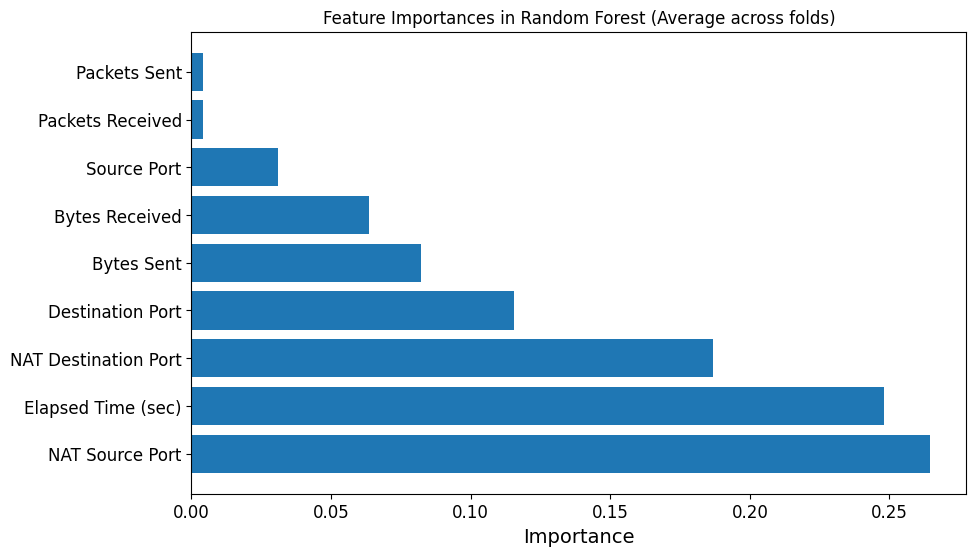

In [33]:
model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=2)

# Stratified KFold cross-validation
skf = StratifiedKFold(n_splits=5)

# Store feature importances for each fold
feature_importances = []

cv_results = cross_validate(model, X, y, cv=skf, return_estimator=True)

for estimator in cv_results['estimator']:
    feature_importances.append(estimator.feature_importances_)

# Calculate and display mean metrics
mean_metrics = {key: np.mean(values) for key, values in cv_results.items() if key.startswith('test_')}
print("Average Metrics across folds:")
for metric, value in mean_metrics.items():
    print(f"  {metric.replace('test_', '').capitalize()}: {value:.4f}")

# Convert the list of feature importances to a DataFrame for easier interpretation
feature_importances = np.array(feature_importances)

# Average the feature importances across folds
mean_importances = feature_importances.mean(axis=0)

# Create a DataFrame with feature names and their corresponding importances
feature_names = X.columns  
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances in Random Forest (Average across folds)')
plt.show()

Interpreting the feature importance graph, we see that the two most important features are NAT Source Port and Elapsed Time. Let's use random forest with a depth of 2 and a singular decision tree with a depth of 2 to test the accuracy of our model using these features. 

Average Accuracy (Decision Tree, max_depth=2): 0.9812
Average Accuracy (Random Forest, n_estimators=100, max_depth=2): 0.9923


NameError: name 'ConfusionMatrixDisplay' is not defined

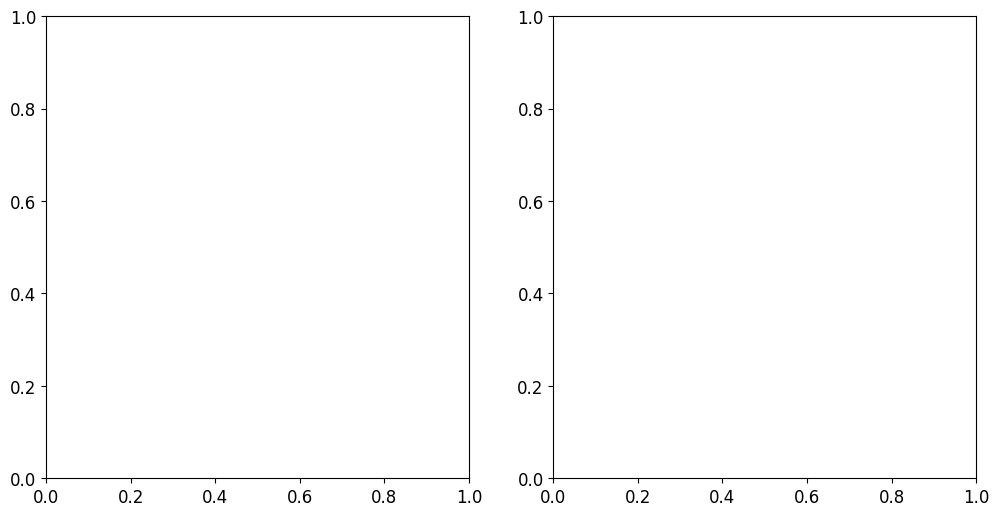

In [34]:
tree_model = DecisionTreeClassifier(max_depth=2, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42)

# Stratified KFold cross-validation
skf = StratifiedKFold(n_splits=5)

# Store metrics and confusion matrices for each fold
tree_accuracies, rf_accuracies = [], []
tree_conf_matrices, rf_conf_matrices = [], []

for train_index, test_index in skf.split(X, y):
    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train and predict with Decision Tree
    tree_model.fit(X_train, y_train)
    tree_preds = tree_model.predict(X_test)
    tree_accuracies.append(accuracy_score(y_test, tree_preds))
    tree_conf_matrices.append(confusion_matrix(y_test, tree_preds))

    # Train and predict with Random Forest
    rf_model.fit(X_train, y_train)
    rf_preds = rf_model.predict(X_test)
    rf_accuracies.append(accuracy_score(y_test, rf_preds))
    rf_conf_matrices.append(confusion_matrix(y_test, rf_preds))

# Average accuracies
avg_tree_accuracy = np.mean(tree_accuracies)
avg_rf_accuracy = np.mean(rf_accuracies)

print(f"Average Accuracy (Decision Tree, max_depth=2): {avg_tree_accuracy:.4f}")
print(f"Average Accuracy (Random Forest, n_estimators=100, max_depth=2): {avg_rf_accuracy:.4f}")

# Visualize confusion matrices for the last fold
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ConfusionMatrixDisplay(tree_conf_matrices[-1], display_labels=tree_model.classes_).plot(ax=axes[0], cmap="Blues")
axes[0].set_title("Decision Tree Confusion Matrix (Last Fold)")

ConfusionMatrixDisplay(rf_conf_matrices[-1], display_labels=rf_model.classes_).plot(ax=axes[1], cmap="Blues")
axes[1].set_title("Random Forest Confusion Matrix (Last Fold)")

plt.tight_layout()
plt.show()

We see that there is not much of a difference between the accuracy of the single decision tree and random forest. We can consider using one decision tree for this data since it computationally inexpensive, especially with a depth of 2. 

2. K-Nearest Neighbor

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Range of k values to test
k_range = range(1, 21)  

# Store the accuracy for each k
knn_accuracies = []

# Stratified K-Fold Cross-Validation for each k value
for k in k_range:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    fold_accuracies = [] 

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        knn_model.fit(X_train, y_train)
        knn_preds = knn_model.predict(X_test)

        fold_accuracies.append(accuracy_score(y_test, knn_preds))

    # Average accuracy for this value of k
    knn_accuracies.append(np.mean(fold_accuracies))

# Plot the elbow curve to find the best value for k
plt.figure(figsize=(8, 6))
plt.plot(k_range, knn_accuracies, marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.title('KNN Elbow Plot (Accuracy vs. k)', fontsize=14)
plt.xlabel('Number of Neighbors (k)', fontsize=12)
plt.ylabel('Average Accuracy', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

The highest accuracy for k looks to be 7, although all the values for k seem to be above 98%. We will stick with k = 7 for this model.

In [ ]:
# Initialize KNN model with 7 neighbors
k_neighbors = 7
knn_model = KNeighborsClassifier(n_neighbors=k_neighbors)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)

knn_accuracies = []
knn_conf_matrices = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    knn_model.fit(X_train, y_train)
    knn_preds = knn_model.predict(X_test)

    knn_accuracies.append(accuracy_score(y_test, knn_preds))
    knn_conf_matrices.append(confusion_matrix(y_test, knn_preds))

# Average accuracy
avg_knn_accuracy = np.mean(knn_accuracies)

print(f"Average Accuracy (KNN, k={k_neighbors}): {avg_knn_accuracy:.4f}")

plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay(knn_conf_matrices[-1], display_labels=knn_model.classes_).plot(cmap="Blues")
plt.title(f"KNN Confusion Matrix (Last Fold, k={k_neighbors})")
plt.show()